Author: Pascal, pascal@bayesimpact.org

Date: 2021-01-12

# ROME update from v344 to v345

In January 2021 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v345. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '344'
NEW_VERSION = '345'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


Cool, no new nor deleted files.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
def read_csv(filename):
    try:
        return pd.read_csv(filename)
    except pd.errors.ParserError:
        display(f'While parsing: {filename}')
        raise

rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

OK no columns have changed.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

9/32282 values added in unix_coherence_item_v345_utf8.csv
13/11765 values added in unix_cr_gd_dp_appellations_v345_utf8.csv
1/13660 values added in unix_item_v345_utf8.csv
22/43923 values added in unix_liens_rome_referentiels_v345_utf8.csv
13/11109 values added in unix_referentiel_appellation_v345_utf8.csv
15/20 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation and liens_rome_referentiels, so let's see more precisely.

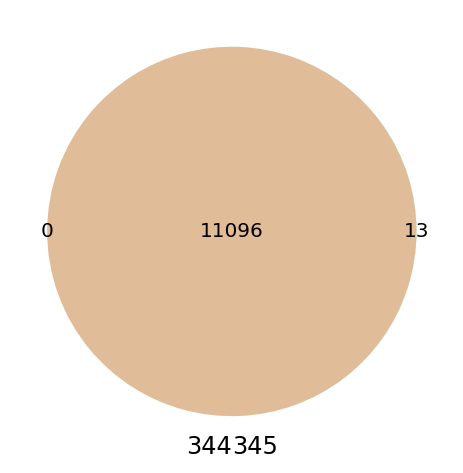

In [6]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 13 new jobs added. Let's take a look (only showing interesting fields):

In [7]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
11096,200140,Conseiller / Conseillère en gestion des droits,C1109
11097,200141,Family office,C1205
11098,200142,Architecte du patrimoine,F1101
11099,200143,Bid manager,H1102
11100,200144,Chargé / Chargée de pharmacovigilance,H1502
11101,200145,Assistant médical / Assistante médicale,J1303
11102,200146,Talent manager,M1502
11103,200147,Product manager,M1703
11104,200148,Chief Technical Officer - CTO,M1802
11105,200149,Project Manager,M1803


Those are indeed new jobs. Some are related to COVID-19 and we finally have my (Pascal) job in there.

OK, let's check at the changes in items:

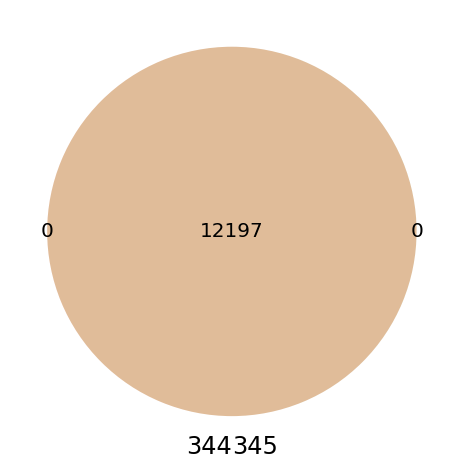

In [8]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

No changes at all, so it's merely existing items that have been newly assigned to existing groups.

The changes in `liens_rome_referentiels` might help reveal those changes:

In [9]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')

old = links.old[['code_rome', 'code_ogr']]
new = links.new[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added    22
Name: _diff, dtype: int64

So there are few fixes. Let's have a look at some of them:

In [10]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(10)

,code_rome,code_ogr,_merge,_diff,job_group_name,item_name


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
43907,J1303,23750,right_only,added,Assistance médico-technique,Cabinet médical
43910,M1703,118732,right_only,added,Management et gestion de produit,"Réaliser une veille documentaire (collecte, analyse etc.)"
43913,M1803,113277,right_only,added,Direction des systèmes d'information,Méthode AGILE
43914,M1803,120879,right_only,added,Direction des systèmes d'information,Système LEAN
43915,M1803,121639,right_only,added,Direction des systèmes d'information,Élaborer une cartographie des risques
43916,M1803,119313,right_only,added,Direction des systèmes d'information,Conduite d'opérations de gestion de crise
43920,M1806,120563,right_only,added,Conseil et maîtrise d'ouvrage en systèmes d'information,Réaliser un reporting
43921,M1806,122886,right_only,added,Conseil et maîtrise d'ouvrage en systèmes d'information,Suivre l'avancement d'un projet
43922,M1806,118867,right_only,added,Conseil et maîtrise d'ouvrage en systèmes d'information,Conduite du changement


The added items are OK (not sure why they weren't in there before).

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v345, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf).

The transition should be transparent with a very small advantage over the old version.